In [ ]:
!pip install opencv-python-headless numpy scipy matplotlib

In [ ]:
import os

# Create data folder
os.makedirs("data", exist_ok=True)

In [ ]:
from google.colab import files
uploaded = files.upload()
# Move your uploaded image to 'data/input.png'
import shutil
shutil.move(list(uploaded.keys())[0], "data/input.png")

Saving input.png to input.png


'data/input.png'

**Guided Filter**

In [ ]:
%%writefile GuidedFilter.py
import numpy as np
import cv2

class GuidedFilter:

    def __init__(self, I, radius=5, epsilon=0.4):
        self._radius = 2 * radius + 1
        self._epsilon = epsilon
        self._I = self._toFloatImg(I)
        self._initFilter()

    def _toFloatImg(self, img):
        if img.dtype == np.float32:
            return img
        return (1.0 / 255.0) * np.float32(img)

    def _initFilter(self):
        I = self._I
        r = self._radius
        eps = self._epsilon

        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        self._Ir_mean = cv2.blur(Ir, (r, r))
        self._Ig_mean = cv2.blur(Ig, (r, r))
        self._Ib_mean = cv2.blur(Ib, (r, r))

        Irr_var = cv2.blur(Ir ** 2, (r, r)) - self._Ir_mean ** 2 + eps
        Irg_var = cv2.blur(Ir * Ig, (r, r)) - self._Ir_mean * self._Ig_mean
        Irb_var = cv2.blur(Ir * Ib, (r, r)) - self._Ir_mean * self._Ib_mean
        Igg_var = cv2.blur(Ig * Ig, (r, r)) - self._Ig_mean ** 2 + eps
        Igb_var = cv2.blur(Ig * Ib, (r, r)) - self._Ig_mean * self._Ib_mean
        Ibb_var = cv2.blur(Ib * Ib, (r, r)) - self._Ib_mean ** 2 + eps

        Irr_inv = Igg_var * Ibb_var - Igb_var * Igb_var
        Irg_inv = Igb_var * Irb_var - Irg_var * Ibb_var
        Irb_inv = Irg_var * Igb_var - Igg_var * Irb_var
        Igg_inv = Irr_var * Ibb_var - Irb_var * Irb_var
        Igb_inv = Irb_var * Irg_var - Irr_var * Igb_var
        Ibb_inv = Irr_var * Igg_var - Irg_var * Irg_var

        I_cov = Irr_inv * Irr_var + Irg_inv * Irg_var + Irb_inv * Irb_var
        Irr_inv /= I_cov
        Irg_inv /= I_cov
        Irb_inv /= I_cov
        Igg_inv /= I_cov
        Igb_inv /= I_cov
        Ibb_inv /= I_cov

        self._Irr_inv = Irr_inv
        self._Irg_inv = Irg_inv
        self._Irb_inv = Irb_inv
        self._Igg_inv = Igg_inv
        self._Igb_inv = Igb_inv
        self._Ibb_inv = Ibb_inv

    def _computeCoefficients(self, p):
        r = self._radius
        I = self._I
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        p_mean = cv2.blur(p, (r, r))
        Ipr_mean = cv2.blur(Ir * p, (r, r))
        Ipg_mean = cv2.blur(Ig * p, (r, r))
        Ipb_mean = cv2.blur(Ib * p, (r, r))

        Ipr_cov = Ipr_mean - self._Ir_mean * p_mean
        Ipg_cov = Ipg_mean - self._Ig_mean * p_mean
        Ipb_cov = Ipb_mean - self._Ib_mean * p_mean

        ar = self._Irr_inv * Ipr_cov + self._Irg_inv * Ipg_cov + self._Irb_inv * Ipb_cov
        ag = self._Irg_inv * Ipr_cov + self._Igg_inv * Ipg_cov + self._Igb_inv * Ipb_cov
        ab = self._Irb_inv * Ipr_cov + self._Igb_inv * Ipg_cov + self._Ibb_inv * Ipb_cov

        b = p_mean - ar * self._Ir_mean - ag * self._Ig_mean - ab * self._Ib_mean

        ar_mean = cv2.blur(ar, (r, r))
        ag_mean = cv2.blur(ag, (r, r))
        ab_mean = cv2.blur(ab, (r, r))
        b_mean = cv2.blur(b, (r, r))

        return ar_mean, ag_mean, ab_mean, b_mean

    def _computeOutput(self, ab, I):
        ar_mean, ag_mean, ab_mean, b_mean = ab
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]
        q = ar_mean * Ir + ag_mean * Ig + ab_mean * Ib + b_mean
        return q

    def filter(self, p):
        p_32F = self._toFloatImg(p)
        ab = self._computeCoefficients(p_32F)
        return self._computeOutput(ab, self._I)


Writing GuidedFilter.py


**run Dehazing**

In [ ]:
'''import cv2
import numpy as np
from GuidedFilter import GuidedFilter
import scipy.ndimage

# ------------- Functions ----------------
def calDepthMap(I, r):
    hsvI = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)
    s = hsvI[:,:,1] / 255.0
    v = hsvI[:,:,2] / 255.0
    sigma = 0.041337
    sigmaMat = np.random.normal(0, sigma, (I.shape[0], I.shape[1]))
    output = 0.121779 + 0.959710*v - 0.780245*s + sigmaMat
    outputPixel = output
    output = scipy.ndimage.minimum_filter(output, (r,r))
    return output, outputPixel

def estA(img, Jdark):
    h,w,c = img.shape
    if img.dtype == np.uint8:
        img = np.float32(img)/255
    # n_bright = int(np.ceil(0.001*h*w))
    n_bright = int(np.ceil(0.0001 * h * w))  # 0.01%

    reshaped_Jdark = Jdark.reshape(1,-1)
    Loc = np.argsort(reshaped_Jdark)
    Ics = img.reshape(1,h*w,3)
    Acand = np.zeros((1,n_bright,3), dtype=np.float32)
    Amag = np.zeros((1,n_bright,1), dtype=np.float32)
    for i in range(n_bright):
        x = Loc[0, h*w-1-i]
        Acand[0,i,:] = Ics[0, x, :]
        Amag[0,i] = np.linalg.norm(Acand[0,i,:])
    reshaped_Amag = Amag.reshape(1,-1)
    Loc2 = np.argsort(reshaped_Amag)
    if len(reshaped_Amag[0])>20:
        A = Acand[0, Loc2[0, n_bright-20:n_bright], :]
    else:
        A = Acand[0, Loc2[0, n_bright-len(reshaped_Amag[0]):n_bright], :]
    return A

# ------------- Main ----------------
inputImagePath = "data/input.png"
r = 15
beta = 1.5
gimfiltR = 60
eps = 1e-3

I = cv2.imread(inputImagePath)
dR,dP = calDepthMap(I, r)
guided_filter = GuidedFilter(I, gimfiltR, eps)
refineDR = guided_filter.filter(dR)
tR = np.exp(-beta * refineDR)
tP = np.exp(-beta * dP)

a = estA(I, dR)
if I.dtype == np.uint8:
    I = np.float32(I)/255

h,w,c = I.shape
J = I - a.mean(axis=0)  # simple broadcast subtraction

t = tR.clip(0.05,1.0)
J = J / t[:,:,None] + a.mean(axis=0)

cv2.imwrite("data/dehazed.png", np.clip(J*255,0,255).astype(np.uint8)) '''
import cv2
import numpy as np
from GuidedFilter import GuidedFilter
import scipy.ndimage

# ---------------------------------------------
# 1) DEPTH MAP (CAP PAPER)
# ---------------------------------------------
def calDepthMap(I, r):
    hsv = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)
    V = hsv[:,:,2] / 255.0
    S = hsv[:,:,1] / 255.0

    # CAP coefficients
    depth = 0.121779 + 0.959710*V - 0.780245*S

    # smooth using min filter (as paper)
    depth_refined = scipy.ndimage.minimum_filter(depth, size=r)

    return depth_refined.astype(np.float32), depth.astype(np.float32)


# ---------------------------------------------
# 2) ATMOSPHERIC LIGHT (correct version)
# ---------------------------------------------
def estA(img, depth):
    h,w,c = img.shape

    if img.dtype != np.float32:
        img = img.astype(np.float32)/255.0

    depth_vec = depth.reshape(-1)
    img_vec = img.reshape(-1,3)

    # select top 0.1% brightest pixels
    n_bright = int(0.001 * h*w)
    idx = np.argsort(depth_vec)[-n_bright:]

    brightest_pixels = img_vec[idx]
    # select maximum intensity pixel
    A = brightest_pixels[np.argmax(brightest_pixels.sum(axis=1))]

    return A.astype(np.float32)


# ---------------------------------------------
# MAIN CAP PIPELINE
# ---------------------------------------------
# ------------- Main ----------------
inputImagePath = "data/input.png"

# CAP parameters
r = 15              # depth filter window
beta = 1.0          # CAP attenuation factor
gimfiltR = 60        # guided filter radius
eps = 1e-3          # guided filter epsilon

# Read and normalize input
I = cv2.imread(inputImagePath)
I = I.astype(np.float32) / 255.0

# 1. Compute depth map (CAP prior)
dR, dP = calDepthMap(I, r)
dR = dR.astype(np.float32)

# 2. Refine depth with guided filter
guided_filter = GuidedFilter((I*255).astype(np.uint8), gimfiltR, eps)
refineDR = guided_filter.filter(dR)

# 3. Transmission map
t = np.exp(-beta * refineDR).astype(np.float32)
t = np.clip(t, 0.05, 1.0)

# 4. Atmospheric light estimation
A = estA(I, dR)
A = A.mean(axis=0)        # convert to [R,G,B]

# 5. Recover scene radiance
J = (I - A) / t[:, :, None] + A
J = np.clip(J, 0, 1)

# 6. Save output
cv2.imwrite("data/dehazed.png", (J * 255).astype(np.uint8))



True

**Run & Check Output**

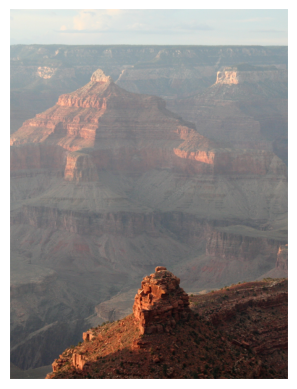

In [ ]:
from matplotlib import pyplot as plt
img = cv2.imread("data/dehazed.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


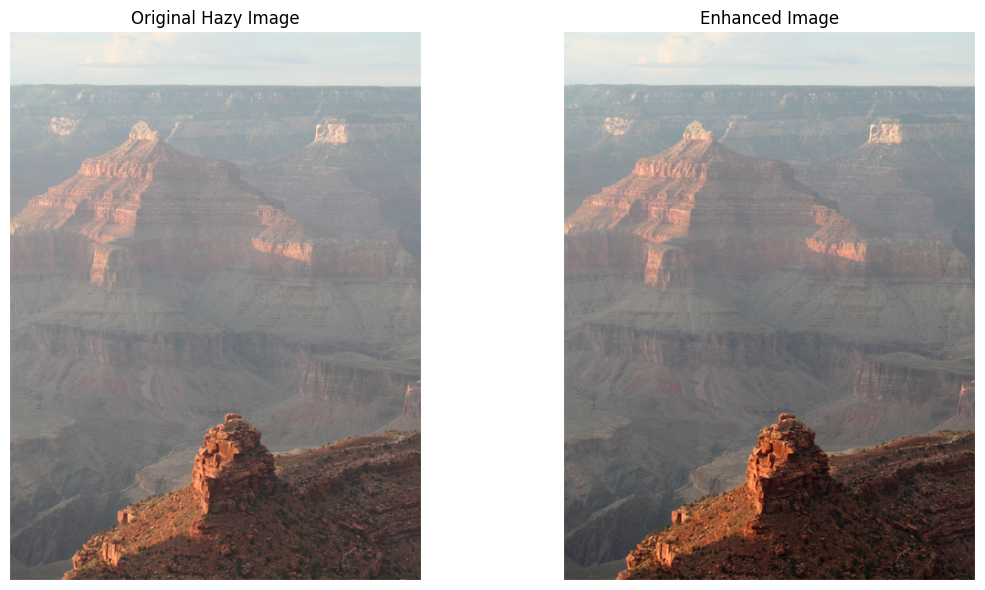

In [ ]:
from matplotlib import pyplot as plt
import cv2

# Read images
original = cv2.imread("data/input.png")      # Original hazy image
enhanced = cv2.imread("data/dehazed.png")   # Enhanced image

# Convert BGR to RGB for proper display in matplotlib
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axes[0].imshow(original_rgb)
axes[0].set_title("Original Hazy Image")
axes[0].axis("off")

axes[1].imshow(enhanced_rgb)
axes[1].set_title("Enhanced Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()


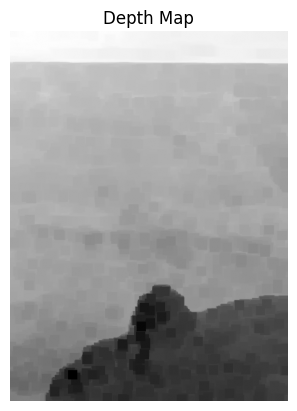

In [ ]:
plt.imshow(dR, cmap='gray'); plt.title('Depth Map'); plt.axis('off'); plt.show()


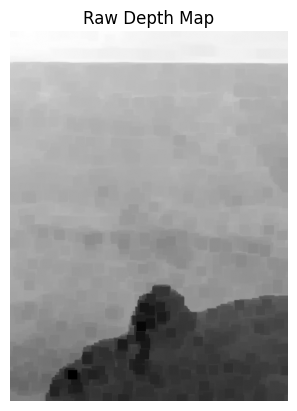

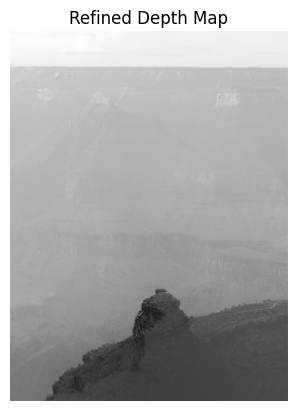

In [ ]:
plt.imshow(dR, cmap='gray')
plt.title("Raw Depth Map")
plt.axis('off')
plt.show()

plt.imshow(refineDR, cmap='gray')
plt.title("Refined Depth Map")
plt.axis('off')
plt.show()


In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")

# Function to evaluate a single image
def evaluate_image(img_path):
    results = model(img_path)  # Run detection

    # Extract predictions
    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy()  # Bounding boxes
        scores = r.boxes.conf.cpu().numpy()  # Confidence
        classes = r.boxes.cls.cpu().numpy()  # Predicted class
        print(f"\nImage: {img_path}")
        print(f"Number of detections: {len(boxes)}")
        for i, (b, s, c) in enumerate(zip(boxes, scores, classes)):
            print(f"Detection {i+1}: Class {int(c)}, Score {s:.2f}, Box {b}")

    # Simple metric: number of detections
    return len(boxes)

# Evaluate ORIGINAL image
orig_detections = evaluate_image("data/input.png")

# Evaluate DEHAZED image
dehazed_detections = evaluate_image("data/dehazed.png")

# Compute delta
delta = dehazed_detections - orig_detections
print(f"\nΔ Number of Detections: {delta}")



image 1/1 /content/data/input.png: 640x480 (no detections), 165.1ms
Speed: 5.0ms preprocess, 165.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

Image: data/input.png
Number of detections: 0

image 1/1 /content/data/dehazed.png: 640x480 (no detections), 153.5ms
Speed: 2.6ms preprocess, 153.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

Image: data/dehazed.png
Number of detections: 0

Δ Number of Detections: 0


PSNR between original and dehazed: 24.72 dB
SSIM between original and dehazed: 0.9743


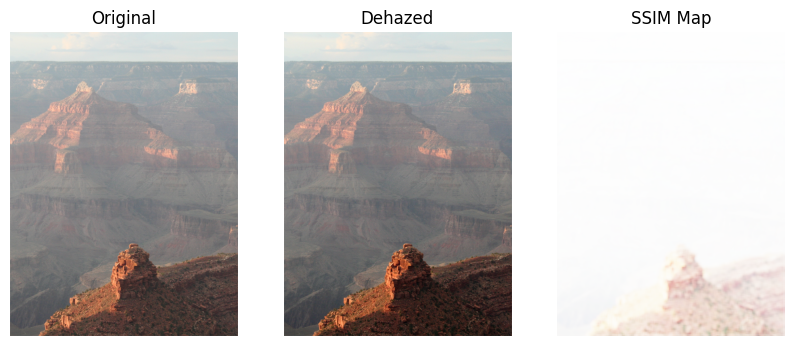

In [ ]:
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# ------------------------------
# Load Images
# ------------------------------
orig = cv2.imread("data/input.png")
dehazed = cv2.imread("data/dehazed.png")

# Convert to RGB for SSIM/visualization
orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
dehazed_rgb = cv2.cvtColor(dehazed, cv2.COLOR_BGR2RGB)

# ------------------------------
# Compute PSNR
# ------------------------------
psnr_value = psnr(orig, dehazed)

# ------------------------------
# Compute SSIM
# ------------------------------
# Use channel_axis=-1 for color images
# Optionally, set win_size to smaller than image dimensions
min_side = min(orig_rgb.shape[0], orig_rgb.shape[1])
win_size = 7 if min_side >= 7 else (min_side // 2 * 2 + 1)  # nearest odd number <= smaller side

ssim_value, ssim_map = ssim(orig_rgb, dehazed_rgb, full=True, channel_axis=-1, win_size=win_size)

# ------------------------------
# Display Results
# ------------------------------
print(f"PSNR between original and dehazed: {psnr_value:.2f} dB")
print(f"SSIM between original and dehazed: {ssim_value:.4f}")

# Optional: Visualize SSIM Map
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(orig_rgb)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Dehazed")
plt.imshow(dehazed_rgb)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("SSIM Map")
plt.imshow(ssim_map, cmap='gray')
plt.axis('off')

plt.show()


===== Dehazing Evaluation Metrics =====
PSNR: 24.7169
SSIM: 0.9743
CII_orig: 44.3734
CII_dehazed: 50.1018
CII_delta: 5.7285
ERI_orig: 0.0184
ERI_dehazed: 0.0208
ERI_delta: 0.0024
Entropy_orig: 4.9502
Entropy_dehazed: 5.0673
Entropy_delta: 0.1172


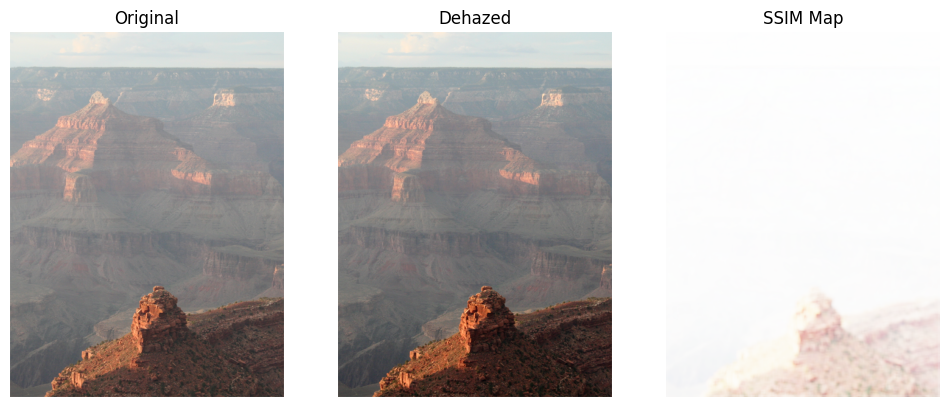

In [ ]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.filters import sobel
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.stats import entropy as scipy_entropy

# ------------------------------
# Function to compute metrics
# ------------------------------
def evaluate_dehazing(orig_path, dehazed_path):
    # Load images
    orig = cv2.imread(orig_path)
    dehazed = cv2.imread(dehazed_path)

    # Convert to RGB
    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    dehazed_rgb = cv2.cvtColor(dehazed, cv2.COLOR_BGR2RGB)

    # PSNR
    psnr_value = psnr(orig, dehazed)

    # SSIM
    min_side = min(orig_rgb.shape[0], orig_rgb.shape[1])
    win_size = 7 if min_side >= 7 else (min_side // 2 * 2 + 1)
    ssim_value, ssim_map = ssim(orig_rgb, dehazed_rgb, full=True, channel_axis=-1, win_size=win_size)

    # Contrast Improvement Index (CII)
    def contrast_index(img):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return gray.std()  # standard deviation as contrast
    cii_orig = contrast_index(orig)
    cii_dehazed = contrast_index(dehazed)
    cii_delta = cii_dehazed - cii_orig

    # Edge Restoration Index (ERI)
    def edge_index(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = sobel(gray)
        return edges.mean()
    eri_orig = edge_index(orig)
    eri_dehazed = edge_index(dehazed)
    eri_delta = eri_dehazed - eri_orig

    # Entropy
    def img_entropy(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0,256])
        hist_norm = hist.ravel()/hist.sum()
        return scipy_entropy(hist_norm + 1e-7)  # avoid log(0)
    entropy_orig = img_entropy(orig)
    entropy_dehazed = img_entropy(dehazed)
    entropy_delta = entropy_dehazed - entropy_orig

    # Compile results
    metrics = {
        "PSNR": psnr_value,
        "SSIM": ssim_value,
        "CII_orig": cii_orig,
        "CII_dehazed": cii_dehazed,
        "CII_delta": cii_delta,
        "ERI_orig": eri_orig,
        "ERI_dehazed": eri_dehazed,
        "ERI_delta": eri_delta,
        "Entropy_orig": entropy_orig,
        "Entropy_dehazed": entropy_dehazed,
        "Entropy_delta": entropy_delta
    }

    return metrics, ssim_map

# ------------------------------
# Run evaluation
# ------------------------------
orig_path = "data/input.png"
dehazed_path = "data/dehazed.png"

metrics, ssim_map = evaluate_dehazing(orig_path, dehazed_path)

# Print results
print("===== Dehazing Evaluation Metrics =====")
for k, v in metrics.items():
    if "delta" in k:
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:.4f}")

# ------------------------------
# Optional: Visualize images and SSIM map
# ------------------------------
orig_img = cv2.cvtColor(cv2.imread(orig_path), cv2.COLOR_BGR2RGB)
dehazed_img = cv2.cvtColor(cv2.imread(dehazed_path), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(orig_img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Dehazed")
plt.imshow(dehazed_img)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("SSIM Map")
plt.imshow(ssim_map, cmap='gray')
plt.axis("off")

plt.show()


In [ ]:
# Example using PyTorch and AOD-Net
from aodnet import AODNet  # hypothetical module
import torch

model = AODNet(pretrained=True)
img_tensor = preprocess_image("data/input.png")  # convert to tensor
with torch.no_grad():
    dehazed_tensor = model(img_tensor)
dehazed_img = postprocess_tensor(dehazed_tensor)
cv2.imwrite("data/dehazed_aodnet.png", dehazed_img)


ModuleNotFoundError: No module named 'aodnet'